In [1]:
# General Imports
from pymongo import MongoClient
import re
import pickle
from collections import defaultdict
import json

# SciPy Stack
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# NLP pre-processing
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer

# sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

In [2]:
# connect to Mongo
client = MongoClient('mongodb://localhost:27017')
# database is 'musicReviews' - this is an artifact from when I also scraped Pitchfork reviews
db = client['musicReviews']

# Loading Data

In [3]:
# load data from Mongo
data = db.boomkat.find({'body': {'$ne':''}, 
                        'genre_style': 'TECHNO / HOUSE'
                         },
                       
                         {'artist':1, 'title':1, 'body':1,
                          'label':1, 'release_date':1, 'url':1
                         }
                        )

In [ ]:
# if you want to experiment with the notebook, you can load the data from json by uncommenting below

# with open('boomkat.json', 'r') as f:
#     data = json.loads(f)

In [4]:
# preview the data - shoutout to Anthony Naples :)
data[0]

{'_id': ObjectId('5d547c4fb19b4d69a25d767a'),
 'url': 'https://boomkat.com/products/fog-fm',
 'artist': ['Anthony Naples'],
 'title': 'Fog FM',
 'release_date': '2019-06-14',
 'label': 'ANS',
 'body': 'Ambient house don Anthony Naples rolls his soul out in ‘Fog FM’, the NYC producer’s 2nd album proper following 2015’s ‘Body Pill’ and last year’s ‘Take Me With You’ mixtape.While Naples own releases have been thin on the ground in recent years, he’s kept his hand in behind the scenes for the Proibito and Incienso labels, and clearly devoted good times to this lush 10 track set swimming between bubbling strains of deep, electroid, and dubbed-out house and techno.Over the course of 61 minutes Naples trades in his most hypnagogic styles in a stealthily deliquescent manner that melts from the fuller bodied silhouette of ‘A.I.R.’ into deliciously illusive, psychedelic swing by the end of the album with ‘Aftermath FM’. What happens in between is a sweetly dazed dream sequence taking in the Shi

**Uh-oh! I was a little too hasty in scraping these reviews and parsed the 'body' of text multiple times, so these need to be deduplicated first.**
(This one repeats five times - "...2019 folder for hazy good times." is the true end of the review)

In [5]:
# create an array of all boomkat releases from the mongo cursor object (data)
boomkat = np.array([release for release in data])
boomkat.shape

(11663,)

In [6]:
# convert to a DataFrame
df = pd.DataFrame.from_records(boomkat)
# preview
df.sample(3)

,_id,artist,body,label,release_date,title,url
7691,5d5a4f5cc770a5bf275141bc,[PHOTONZ],Photonz return to Semtek's Don't Be Afraid lab...,Don't Be Afraid,2012-02-20,Love Spectre EP,https://boomkat.com/products/love-spectre-ep-4...
9951,5d5a67dbc770a5bf27517d56,[Bruno Pronsato & Minimono],"A great split release on new label Bosconi, pa...",Bosconi Records,2008-11-24,That's Amore EP,https://boomkat.com/products/that-s-amore-ep?t...
3604,5d59d303c770a5bf2750acfc,[Finn],"Infamous Kangaroo hater and R&G/Club dynamo, F...",2 B Real,2017-05-05,Late at Night / Lightwork,https://boomkat.com/products/late-at-night-lig...


# Dataset Preprocessing

### Correcting Artist Column

In [7]:
# each artist column is a list of string(s)
df.artist.sample(5)

8682                          [Ellen Allien]
10453                             [Redshape]
2249     [Special Request feat. Nina Kraviz]
5275                           [JACK MURPHY]
9784                 [DJ HELL / RADIO SLAVE]
Name: artist, dtype: object

That's gonna be an annoying data structure to work with.  Let's see if we can break it down to column(s) of strings.

In [8]:
# unravel artist column (list of strings) into two columns
artists = pd.DataFrame(df.artist.values.tolist(), columns=['artists', '_'])
artists.head()

,artists,_
0,Anthony Naples,None
1,LSD,None
2,Blawan,None
3,Efdemin,None
4,DONATO DOZZY,None


In [9]:
# only two rows had more than one artist name in the list
artists[artists['_'].notna()]

,artists,_
4229,THE SOFT MOON,ANCIENT METHODS
7208,Guillaume & the Coutu Dumonts,Guillaume & the Coutu Dumonts


*I happen to know that Ancient Methods has a few other records in this dataset so we can ignore the second column '_'*

In [10]:
# reset artist column to just strings
df['artist'] = artists['artists']

### Fixing Duplicate Body Text

In [11]:
def remove_duplicate_body_text(doc):
    '''
    Deduplicates repeated text in a document.
    '''
    # create a delimiter with the first 40 characters
    first40char = doc[:40]
    # split the document on the first40char delimiter; 
    # grab the first split after first40chars
    to_join_text = doc.split(first40char)[1]
    # join these two strings; all repeated text will have been filtered out
    return first40char + to_join_text

In [12]:
# apply function to column
df['body'] = df.body.apply(remove_duplicate_body_text)

In [13]:
df['body'].iloc[0]

'Ambient house don Anthony Naples rolls his soul out in ‘Fog FM’, the NYC producer’s 2nd album proper following 2015’s ‘Body Pill’ and last year’s ‘Take Me With You’ mixtape.While Naples own releases have been thin on the ground in recent years, he’s kept his hand in behind the scenes for the Proibito and Incienso labels, and clearly devoted good times to this lush 10 track set swimming between bubbling strains of deep, electroid, and dubbed-out house and techno.Over the course of 61 minutes Naples trades in his most hypnagogic styles in a stealthily deliquescent manner that melts from the fuller bodied silhouette of ‘A.I.R.’ into deliciously illusive, psychedelic swing by the end of the album with ‘Aftermath FM’. What happens in between is a sweetly dazed dream sequence taking in the Shinichi Atobe-esque dub-house thizz of ‘Fog FM’ and pulsating, sexy techno on ‘Purple Iris’, along with desiccated but sublime ambient pockets in ‘Channel 2’ and ‘Channel 3’, as the album begin to gently

> MUCH BETTER!

#### Album Deduplication

**Some albums were released in multiple formats (vinyl, mp3, flac). These albums might appear several times in our corpus - throwing off our vectorizer.  We should deduplicate these releases:**

In [14]:
# create a column that concatenates release 'title' and 'artist'
df['t&a'] = df.title + "_" + df.artist.astype(str)

In [15]:
# show which albums have duplicates
duplicate_mask = df.duplicated(subset='t&a', keep=False)
df[duplicate_mask].head(2)

,_id,artist,body,label,release_date,title,url,t&a
0,5d547c4fb19b4d69a25d767a,Anthony Naples,Ambient house don Anthony Naples rolls his sou...,ANS,2019-06-14,Fog FM,https://boomkat.com/products/fog-fm,Fog FM_Anthony Naples
1,5d54986956a5e6c5afc7b7f0,LSD,"Searing, panic-on-the-space-station techno fro...",Ostgut Ton,2017-11-17,Process,https://boomkat.com/products/process-db83a0f6-...,Process_LSD


In [16]:
# example
df[df['t&a'] == 'Fog FM_Anthony Naples']

,_id,artist,body,label,release_date,title,url,t&a
0,5d547c4fb19b4d69a25d767a,Anthony Naples,Ambient house don Anthony Naples rolls his sou...,ANS,2019-06-14,Fog FM,https://boomkat.com/products/fog-fm,Fog FM_Anthony Naples
765,5d598249c770a5bf27503ef9,Anthony Naples,Ambient house don Anthony Naples rolls his sou...,ANS,2019-06-14,Fog FM,https://boomkat.com/products/fog-fm?taxon_id=1...,Fog FM_Anthony Naples


In [17]:
# get rid of duplicate albums so that the documents are unique
df.drop_duplicates(subset='t&a', inplace=True)

In [18]:
# sanity check - no album should have more than one value_count
df['t&a'].value_counts().sort_values(ascending=False).head(3)

Improvisations EP_Gardland      1
Unravelled (Vol. 1)_Various     1
Primordia (Reissue)_Deadbeat    1
Name: t&a, dtype: int64

## Lastly:

In [19]:
# isolate the corpus
corpus = df.body.copy()

# EDA I - Raw Data

#### What's the Word Count distribution for our Docs?

In [20]:
# split each document and get word counts
wc = corpus.str.split().str.len()
wc.describe()

count    11083.000000
mean        95.856447
std         58.510892
min          5.000000
25%         60.000000
50%         83.000000
75%        116.000000
max        724.000000
Name: body, dtype: float64

Text(0, 0.5, 'Document Count')

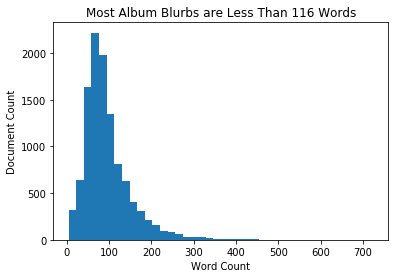

In [21]:
plt.hist(wc, bins=40)
plt.title('Most Album Blurbs are Less Than 116 Words')
plt.xlabel('Word Count')
plt.ylabel('Document Count')

## Convert to Bag-of-Words Format

#### Stopwords

In [22]:
from sklearn.feature_extraction import text
# this list was built up iteratively, by evaluating the words that had considerable overlap
# in many of my topic models - they also tend to deal with aspects about a physical release, 
# not the stylistic concerns of a piece of music
extra_stopwords = ['album', 'remix', 'house', 'techno',
                   'new', 'label', 'release', 'debut',
                   'mix', 'title', 'producer', 'original', 
                   'remastered', 'music', 'reissue', 'like',
                   '12', '75', '16', 'ep', 'volumes', 'singles',
                   'volume', 'lp', 'vinyl', 'released', 'record',
                   'reworks', 'edition', '13', '14', '15',
                   'remixes', 'rework', 'featuring', 'exclusive',
                   'releases', 'just', 'production', 'split', 'recent',
                   'final'
                  ]

# add em to the standard sklearn english stopword
my_stop_words = text.ENGLISH_STOP_WORDS.union(extra_stopwords)

### Vectorize

In [23]:
# instantiate tf-idf vectorizer with standard preprocessor and tokenizer, max_df was iteratively determined
tfidf = TfidfVectorizer(stop_words=my_stop_words, max_df = .2)

In [24]:
# create document-term matrix
doc_words = tfidf.fit_transform(corpus)
doc_words.shape

(11083, 51029)

In [25]:
# preview of what a document's top tf-idf terms are
sample=doc_words[210]
# transpose document-vector, map word from tf-idf input back to tf-idf weights
sample_tfidf = pd.DataFrame(sample.T.todense(), index=tfidf.get_feature_names(), columns=["tfidf"])
# sort by weights descending
sample_tfidf.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
irresisitible,0.189062
discotheques,0.189062
leotard,0.189062
exhibitionist,0.181094
rumpus,0.181094


# Topic Modeling via NMF

In [26]:
# decompose tf-idf matrix via NMF; number of components determined iteratively and subjectively
nmf_model = NMF(13, random_state=666)
# doc_topic is the low-rank 'U' matrix 
doc_topic = nmf_model.fit_transform(doc_words)
# topics_words low-rank 'V' matrix; topics by words where values are the weights for each word in a topic
topics_words = pd.DataFrame(nmf_model.components_, columns=tfidf.get_feature_names())

**NMF produced the most interpretable topics over LDA, TruncSVD, and K-means clustering** . You're welcome to substitute a different method in the above cell to experiment.

# EDA II - Exploring Topics

In [27]:
# convenience function to list top words for each topic
def explore_topics(model, feature_names, top_n_words, offset=0, topic_names=None):
    '''
    Function that prints top N words for each topic in a topic-model or matrix decomposition model.
    
    Parameters
    ----------
    model : some class from sklearn.decomposition or similar
        A fit topic-model or similar - MUST HAVE a "components_" attribute.
    feature_names : array-like
        Vocabulary list, ordered as it was when the matrix was fed into model.
        e.g. the columns of your document-term matrix
    top_n_words : int
        Cut-off for top words displayed.
    offset : int, default 0
        Optional initial offset for top_n_words. 
    topic_names : array-like, default None
        Optional convenience parameter to label your topics after you've interpreted them.
        Default behavior is to label topics numerically from 0 to n_topics.
    '''
    
    topic_word_matrix = model.components_
    
    # iterate through topic-word matrix by row
    for ix, topic in enumerate(topic_word_matrix):
        
        # HEADER:
        # if no topic_names specified, list topics with numerical identifier
        if topic_names is None or topic_names[ix] is None: 
            print(f"\nTopic {ix}")
        # if topic_names specified, list topic with label
        else:                                              
            print(f"\nTopic: '{topic_names[ix]}'")
        
        # GETTING TOP WORDS FOR EACH TOPIC
        # argsort each topic (row) descending to get indices of greatest value
        # slice array down to top n_words; pass this array back to original vocabulary vector
        top_words = [feature_names[i] for i in topic.argsort()[::-1][offset:offset+top_n_words]]
        
        # stringify with comma delimiter
        top_words_string = ", ".join(top_words)
        # print top_n_words
        print(top_words_string)

In [28]:
# display 10 words per topic
explore_topics(nmf_model, tfidf.get_feature_names(), 10)


Topic 0
industrial, noise, kicks, ebm, regis, dettmann, perc, killer, black, dark

Topic 1
track, beats, beat, vocal, percussion, bassline, minimal, sounds, little, kompakt

Topic 2
acid, 303, chicago, jack, style, raw, lines, tin, man, moss

Topic 3
detroit, classic, soul, carl, craig, omar, style, chicago, 313, funk

Topic 4
trax, digital, legendary, perc, chicago, raw, jack, optimo, track, series

Topic 5
disco, boogie, italo, cosmic, filtered, edit, funk, balearic, pop, thomas

Topic 6
electro, funk, synth, styles, style, boogie, breaks, dutch, drexciyan, pads

Topic 7
tech, minimal, minimalism, deeper, pop, berlin, version, proggy, trance, groove

Topic 8
tracks, sound, years, time, dj, dance, club, electronic, long, work

Topic 9
deep, vibes, jazz, keys, theo, lush, soul, grooves, warm, parrish

Topic 10
dub, chords, chord, echocord, rhythm, moeller, berlin, version, channel, heads

Topic 11
garage, chords, swing, drums, groove, uk, style, subs, london, rolling

Topic 12
big, ro

### Preliminary Evaluation

You probably need a little bit of background in the electronic music world to glean meaning from these topics, but they jump out as pretty distinct sub-genres to me.  They tend to focus around regional/historical styles, which is why you see cities like Detroit, Chicago, London and Berlin pop up.

I've labeled them as such:

In [29]:
topics = [
    "INDUSTRIAL/EBM/NOISE", "maybe boring?",  "CHICAGO/JACKING/ACID", "CLASSIC DETROIT", 
    "TRAX-IN-TITLE", "DISCO/FUNK/ITALO", "ELECTRO/SCI-FI", "MINIMAL/TECH-HOUSE",  
     "UNSURE", "DEEP/SOULFUL-HOUSE", "DUB/BASIC CHANNEL",  "UKG/BREAKBEAT", "BIG ROOM"]

In [30]:
# display 10 words per topic with associated topic labels
explore_topics(nmf_model, tfidf.get_feature_names(), 10, topic_names=topics)


Topic: 'INDUSTRIAL/EBM/NOISE'
industrial, noise, kicks, ebm, regis, dettmann, perc, killer, black, dark

Topic: 'maybe boring?'
track, beats, beat, vocal, percussion, bassline, minimal, sounds, little, kompakt

Topic: 'CHICAGO/JACKING/ACID'
acid, 303, chicago, jack, style, raw, lines, tin, man, moss

Topic: 'CLASSIC DETROIT'
detroit, classic, soul, carl, craig, omar, style, chicago, 313, funk

Topic: 'TRAX-IN-TITLE'
trax, digital, legendary, perc, chicago, raw, jack, optimo, track, series

Topic: 'DISCO/FUNK/ITALO'
disco, boogie, italo, cosmic, filtered, edit, funk, balearic, pop, thomas

Topic: 'ELECTRO/SCI-FI'
electro, funk, synth, styles, style, boogie, breaks, dutch, drexciyan, pads

Topic: 'MINIMAL/TECH-HOUSE'
tech, minimal, minimalism, deeper, pop, berlin, version, proggy, trance, groove

Topic: 'UNSURE'
tracks, sound, years, time, dj, dance, club, electronic, long, work

Topic: 'DEEP/SOULFUL-HOUSE'
deep, vibes, jazz, keys, theo, lush, soul, grooves, warm, parrish

Topic: 'DUB/B

# Extracting Descriptive Terms from Topics

In [31]:
# top terms for Topic 0: Industrial/EBM/Noise
topics_words.iloc[0].sort_values(ascending=False).head(20)

industrial    1.016546
noise         0.678612
kicks         0.518908
ebm           0.495408
regis         0.378310
dettmann      0.365318
perc          0.363197
killer        0.343260
black         0.314224
dark          0.302272
marcel        0.288735
surgeon       0.279896
rhythms       0.275153
proper        0.262084
monotone      0.236981
drones        0.233478
synth         0.230106
silent        0.229248
dry           0.225933
berlin        0.224058
Name: 0, dtype: float64

**Since I'm interested in the qualitative and descriptive differences between sub-genres, we'll restrict the corpus vocabulary to just the *adjectives and adverbs*.**

Parts-of-speech tagging needs to be done on a corpus pre-conversion to a bag-of-words format, since the part-of-speech of some words will be dependent on their context.  

For example:

In [32]:
# 'mutant' can be used as an adjective
TextBlob('That song sounds mutant.').tags

[('That', 'DT'), ('song', 'NN'), ('sounds', 'VBZ'), ('mutant', 'JJ')]

In [33]:
# 'mutant' is also commonly used as a noun
TextBlob('Well, the songwriter is a mutant.').tags

[('Well', 'RB'),
 ('the', 'DT'),
 ('songwriter', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('mutant', 'NN')]

So we'll perform the following on the original *un-tokenized* corpus:

In [34]:
def create_descriptors_list(corpus):
    '''
    Filters a corpus for just the adjectives and adverbs.
    
    Parameters
    ----------
    corpus : array-like
        Array or Series of documents
    
    Returns
    -------
    descriptors_list : set
        All unique adjectives and adverbs from the corpus
    '''
    # initialize set
    descriptors_list = set()
    # loop through documents in corpus
    for idx, doc in enumerate(corpus):
        # poor-mans status update; print a notification after every 3000 iterations
        if idx % 3000 == 0:
            print(f'Starting job #{idx}')
        # convert document to TextBlob object
        blob = TextBlob(doc)
        # iterate through tokens using 'tags' attribute
        for token, tag in blob.tags:
            # if the token is an adj/adv AND has more than 2 characters
            if (tag in ['JJ', 'JJR', 'JJS', 
                        'RB', 'RBR', 'RBS']) & (len(token) > 2):
                
                # add it to the set of descriptors
                descriptors_list.add(token.lower())
                
    return descriptors_list

In [35]:
# create vocabulary of descriptor terms
%time descriptors = create_descriptors_list(corpus)

Starting job #0
Starting job #3000
Starting job #6000
Starting job #9000
CPU times: user 1min 44s, sys: 2.01 s, total: 1min 46s
Wall time: 1min 53s


### Unhelpful Descriptors

In [36]:
# list of terms that either explicitly reference the topic itself or have too much overlap over many topics
unhelpful_descriptors = ['berlin', '2nd', 'killer', 'inspired', 'styled', 'synth',
                         'originally', 'synthline', 'legendary', 'download', 'finally',
                         'mid', 'dancefloor', 'german', 'modern', 'amsterdam',
                         'cool', 'likes', 'material', 'really', 'classic', 'come',
                         'square', 'end', 'key', 'stuff', 'flipside', 'tip', 
                         'step', 'tune', 'remixed', 'flip', 'slow', 'jams', 'skool',
                         'tempo', 'synths', 'seminal', 'bonus', 'east', 'early',
                         'secondly', 'limited', 'recommended', 'classically', 'exactly',
                         'tinged']

In [37]:
# more terms to filter out that explicitly reference topics
styles = ['breakbeat', 'rave', 'italo', 'breaks', 'trance', 'garage', 'warehouse', 'pop', 
          'vocal', 'electronica'
         ]

In [38]:
# create list of artist names to filter out from 'artist' column of original dataframe
artist_names = df.artist.tolist()

In [39]:
# concatenate lists
unhelpful_descriptors.extend(artists)
unhelpful_descriptors.extend(styles)

### Filter for Descriptors

In [40]:
# convenience function
def get_descriptors(topic_word_matrix, topic_num):
    '''
    Filters a topic-word matrix (low-rank V matrix) to only yield adjectives/adverbs that
    end in "-y", "-ed", "-ing", "-ic".
    '''
    # filter topic-word matrix by topic ID (row); 
    topic = topic_word_matrix.iloc[topic_num].sort_values(ascending=False)
    mask = (topic.index.isin(descriptors)) & \
           (topic > 0) & \
          ~(topic.index.isin(unhelpful_descriptors)) & \
           (topic.index.str.contains('[a-z]+y$|[a-z]+ed|[a-z]+ing|[a-z]+ic$'))
    return topic[mask]

In [41]:
# top terms for Topic 0: Industrial/EBM/Noise (repeated cell for comparison)
topics_words.iloc[0].sort_values(ascending=False).head(15)

industrial    1.016546
noise         0.678612
kicks         0.518908
ebm           0.495408
regis         0.378310
dettmann      0.365318
perc          0.363197
killer        0.343260
black         0.314224
dark          0.302272
marcel        0.288735
surgeon       0.279896
rhythms       0.275153
proper        0.262084
monotone      0.236981
Name: 0, dtype: float64

In [42]:
# just the 'descriptors' for Topic 0: Industrial/EBM/Noise
get_descriptors(topics_words, 0).head(15)

dry         0.225933
shifted     0.213557
heavy       0.195969
hypnotic    0.183924
eyed        0.177464
stripped    0.167512
droning     0.167474
pounding    0.163745
roiling     0.161303
body        0.147785
rolling     0.144387
metallic    0.143184
deadly      0.135473
bruising    0.122689
grinding    0.115760
Name: 0, dtype: float64

Compare the before and after - filtering for just the descriptive terms paints a slightly more vivid picture of the aesthetics for this sub-genre of music.

And notice how it's different from descriptive lexicon for Detroit techno: 

In [58]:
# just the 'descriptors' for Topic 3: Classic Detroit
get_descriptors(topics_words, 3).head(15)

red              0.064136
funked           0.053858
shed             0.053811
stripped         0.053541
wicked           0.052993
booty            0.049384
classy           0.049193
influenced       0.048441
uplifting        0.045448
deeply           0.044231
tracky           0.040811
sophisticated    0.038801
rugged           0.038473
dolly            0.035924
rooted           0.034596
Name: 3, dtype: float64

A more "Detroit-style" or "Classic" techno record is less characterized by the aggressive and pseudo-violent terms that describe Industrial/EBM.  There is more reference to a sophisticated funk and uplifting soul, which is similar to how I think the original pioneers of Detroit techno have described their sound in interviews - classy, future funk.  Look up the Belleville Three if you're interested.

Let's investigate the top albums for these topics to have a reference point for how these descriptors map to some example albums.

# Exploring Top Albums per Topic

#### Map Releases to Topics

In [44]:
# reindex doc_topic matrix with album_artist label
release_topic = pd.DataFrame(doc_topic, index=df['t&a'])

#### Assign Releases to Majority Topic

In [45]:
def get_majority(row):
    '''
    Assigns document to it's majority topic.
    '''
    # order topics for each document descending
    doc2topic_ordering = np.argsort(-row.to_numpy())
    # if majority topic is id 8 or 1, adjust majority label to 2nd best
    # note: topics id 1 & 8 were the vague ones
    if doc2topic_ordering[0] in [8,1]:
        adjusted_majority = doc2topic_ordering[1]
        # if next best label also in id 1 or 8 use 3rd best instead
        if adjusted_majority in [8,1]:
            return int(doc2topic_ordering[2])
        else:
            return adjusted_majority
    else:
        return int(doc2topic_ordering[0])

In [46]:
# assign album to majority topic
release_topic['adj_majority'] = release_topic.apply(get_majority, axis=1)

#### Fetch Exemplary Albums

In [47]:
def top_releases_for_topic(r_t_matrix, topic, top_n):
    '''
    Get top releases for each assigned topic.
    
    Parameters
    ----------
    r_t_matrix : DataFrame
        Document-topic matrix with release names mapped as index.
    topic : int
        Topic ID number, index starting at 0.
    top_n : int
        Top number of releases for the topic.
    
    Returns
    -------
    top_n_releases : DataFrame
        Top releases for given topic ID, sorted descending per that column.  
        All topic distribution values are also included in their respective columns.
    '''
    # filter releases for those where adjusted majority belongs to topic
    mask = r_t_matrix.adj_majority == topic
    # sort releases descending for topic value
    # Note: the mask is a safeguard for albums that got reassigned to a different
    # topic via the get_majority function.  In practice it might not be necessary
    # for for sorting values - these reassigned albums likely yield lower values for
    # their new topics...
    top_n_releases = r_t_matrix[mask].sort_values(topic, ascending=False)
    
    # keep only the top_n releases
    return top_n_releases.head(top_n)

In [48]:
# example: get top releases for Topic 0: Industrial/EBM/Noise
top_releases_for_topic(release_topic, 0, 10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,adj_majority
t&a,,,,,,,,,,,,,,
Interior_O/V/R,0.084843,0.014624,0.000930,0.000000,0.000000,0.000000,0.000000,0.000529,0.000805,0.007286,0.003389,0.000000,0.000000,0
Eschaton EP_Eschaton (Ancient Methods & Orphx),0.077876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019688,0.000000,0.000000,0.000000,0.006861,0.000000,0
Berghain 09_Vatican Shadow,0.075246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019569,0.000000,0.000000,0.000000,0.000000,0
Remix Collection Vol. 6_Various / Perc Trax,0.070226,0.000000,0.000000,0.000000,0.036688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Helping The Police With Their Enquiries EP_He/aT,0.069557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019857,0.000000,0
Negative Fascinations (Single)_SILENT SERVANT,0.066556,0.010960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034062,0.001987,0.033731,0.000000,0.000000,0
Endless September (w/ Vapauteen / Perc Mixes)_Furfriend,0.066167,0.004078,0.000000,0.000000,0.028940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Bicycle Day EP_LET'S GO OUTSIDE,0.063011,0.005401,0.030496,0.010014,0.000000,0.000000,0.000000,0.002796,0.022771,0.000000,0.002524,0.000000,0.000000,0
Live from Somewhere_Northern Structures,0.062702,0.000000,0.000000,0.000000,0.000000,0.000000,0.004516,0.000000,0.000000,0.000000,0.000000,0.030501,0.000000,0


# Putting it All Together

#### Visualizing Sub-Genre Descriptors

In [49]:
# get all descriptor terms for Industrial/EBM
industrial_desc = get_descriptors(topics_words, 0)

In [50]:
# generate wordcloud
wc = wordcloud.WordCloud(width = 1200, height = 800, 
                    stopwords=list(my_stop_words)+unhelpful_descriptors,
                    random_state=0, 
                    min_font_size = 10).generate_from_frequencies(industrial_desc)

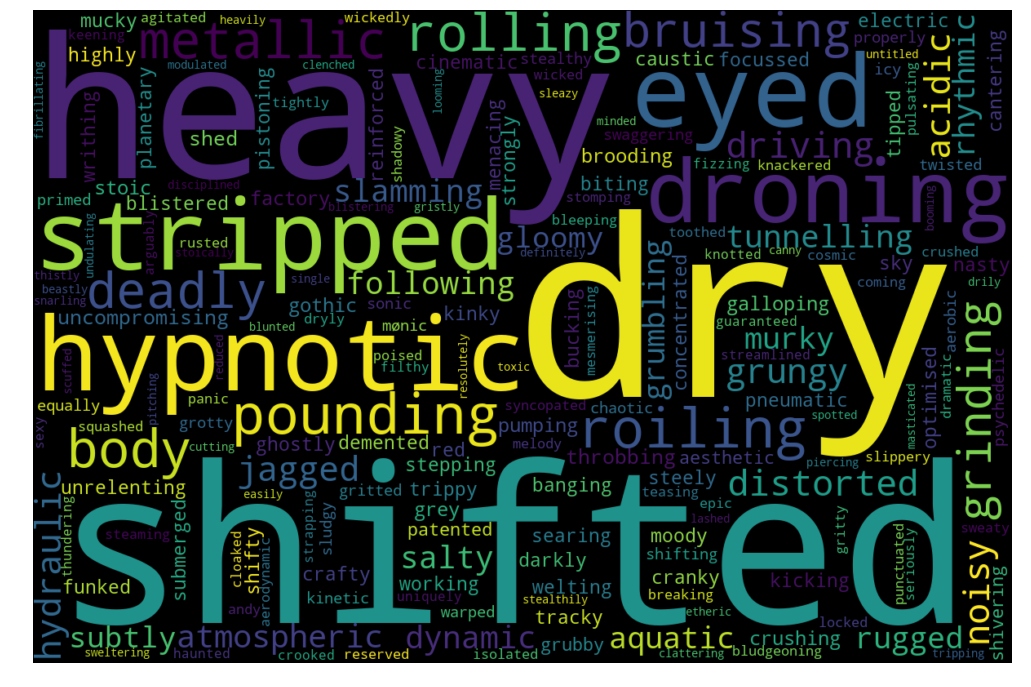

In [51]:
# display wordcloud
plt.figure(figsize=(20,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
# save to file
wc.to_file("industrial_wc2.jpg")

### How do these albums sound?

In [52]:
# get release identifier for Top 20 Industrial releases
industrial = top_releases_for_topic(release_topic, 0, 10)

In [53]:
# merge metadata onto top industrial releases
industrial = industrial.merge(df, left_index=True, right_on='t&a')
# we need wider columns to see full url
pd.set_option('max_colwidth', 1000)
# subset DataFrame for title, artist, and URL
industrial[['title', 'artist', 'url']]

,title,artist,url
9536,Interior,O/V/R,https://boomkat.com/products/interior-f7433150-c015-4ef6-a964-c2289746c12a?taxon_id=107763
5799,Eschaton EP,Eschaton (Ancient Methods & Orphx),https://boomkat.com/products/eschaton-ep-cf731164-a154-4160-8739-28b1e552a66d?taxon_id=107763
736,Berghain 09,Vatican Shadow,https://boomkat.com/products/panorama-bar-09
6999,Remix Collection Vol. 6,Various / Perc Trax,https://boomkat.com/products/remix-collection-vol-6?taxon_id=107763
5079,Helping The Police With Their Enquiries EP,He/aT,https://boomkat.com/products/helping-the-police-with-their-enquiries-ep?taxon_id=107763
9161,Negative Fascinations (Single),SILENT SERVANT,https://boomkat.com/products/negative-fascinations-single?taxon_id=107763
1416,Endless September (w/ Vapauteen / Perc Mixes),Furfriend,https://boomkat.com/products/endless-september-w-vapauteen-perc-mixes?taxon_id=107763
513,Bicycle Day EP,LET'S GO OUTSIDE,https://boomkat.com/products/bicycle-day-ep
7269,Live from Somewhere,Northern Structures,https://boomkat.com/products/live-from-somewhere?taxon_id=107763
8624,Vavasofa EP,Sawf,https://boomkat.com/products/vavasofa-ep?taxon_id=107763


Peep the urls for previews!

# Does that match up to your expectations given the descriptors above?

### Now you have a way to develop a vocabulary for different House/Techno sub-genres.

In [54]:
# close connection to Mongo
client.close()